In [0]:
import os
import re
import datetime
import numpy as np
from PIL import Image
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def generate_data(x, t):
  datagen = ImageDataGenerator(
    #rotation_range=180,     # randomly rotate images in the range
    zoom_range=0.2,         # randomly zoom image
    width_shift_range=0.2,  # randomly shift images horizontally
    height_shift_range=0.2, # randomly shift images vertically
    horizontal_flip=True,   # randomly flip images horizontally
    #vertical_flip=True      # randomly flip images vertically
  )

  x_list = []
  t_list = []

  x_array = np.expand_dims(x, axis=0)

  datagen.fit(x_array)

  iter = datagen.flow(x_array, batch_size=1)

  for i in range(5):
    ret = iter.next()
    #print(ret.shape, ret.dtype)
    x_list.append(ret[0])
    t_list.append(t)

  return x_list, t_list

In [0]:
def prepae_data():
    x, t = [], []

    categorized_dir_paths = glob('/content/drive/My Drive/kikagaku/novelapp/data/images/categorized-2/*')

    for dir_path in categorized_dir_paths:
        category_id = os.path.basename(dir_path)
        image_paths = glob(os.path.join(dir_path, '*'))
        print(datetime.datetime.now().isoformat(), 'Category', category_id, ':', len(image_paths))

        for i, p in enumerate(image_paths):
            book_id = re.sub(r'(_.*$)', '', os.path.basename(p))

            if i % 30 == 0:
                print(datetime.datetime.now().isoformat(), 'Image:', i, book_id, category_id)

            try:
                img = Image.open(p)
                img_resize = img.resize((229, 229))
                img_np = np.array(img_resize) / 255.0

                x.append(img_np)
                t.append(category_id)

                x_gen, t_gen = generate_data(img_np, category_id)
                x.extend(x_gen)
                t.extend(t_gen)

            except Exception as e:
                print(datetime.datetime.now().isoformat(), 'Error:', e)

    return x, t

In [5]:
x, t = prepae_data()

2020-06-06T07:22:06.773420 Category 0 : 117
2020-06-06T07:22:06.774439 Image: 0 1015 0
2020-06-06T07:22:29.247846 Image: 30 1228 0
2020-06-06T07:22:49.827537 Image: 60 1106 0
2020-06-06T07:23:10.104459 Image: 90 1129 0
2020-06-06T07:23:28.212734 Category 1 : 119
2020-06-06T07:23:28.213403 Image: 0 3636 1
2020-06-06T07:23:48.358011 Image: 30 3722 1
2020-06-06T07:24:08.935267 Image: 60 3832 1
2020-06-06T07:24:28.697288 Image: 90 3777 1
2020-06-06T07:24:47.627966 Category 2 : 129
2020-06-06T07:24:47.629101 Image: 0 3601 2
2020-06-06T07:25:08.534034 Image: 30 3884 2
2020-06-06T07:25:28.470506 Image: 60 3778 2
2020-06-06T07:25:49.520178 Image: 90 3853 2
2020-06-06T07:26:09.259614 Image: 120 1502 2
2020-06-06T07:26:15.179287 Category 3 : 111
2020-06-06T07:26:15.179563 Image: 0 3312 3
2020-06-06T07:26:35.116883 Image: 30 2350 3
2020-06-06T07:26:55.237592 Image: 60 3010 3
2020-06-06T07:27:14.721129 Image: 90 3105 3


In [6]:
print(len(x), len(t))

2856 2856


In [7]:
x = np.array(x).astype('f')
t = np.array(t).astype('f')
print(x.shape, t.shape)

(2856, 229, 229, 3) (2856,)


In [0]:
import tensorflow as tf
from tensorflow import keras

In [0]:
from sklearn.model_selection import train_test_split
x_train, x_val, t_train, t_val = train_test_split(x, t, test_size=0.3, random_state=0)

In [10]:
print(x_train.shape, x_val.shape)

(1999, 229, 229, 3) (857, 229, 229, 3)


In [0]:
import os
import random

def reset_seed(seed=0):
    os.environ['PYTHONHASHSEED'] = '0'
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [0]:
reset_seed(0)

In [13]:
category_count = len(np.unique(t))
print(np.unique(t))
print(category_count)

[0. 1. 2. 3.]
4


In [0]:
from tensorflow.keras import models, layers
from tensorflow.keras.applications import Xception

In [21]:
model_fine = Xception(include_top=False, weights='imagenet', input_shape=x_train.shape[1:])

for layer in model_fine.layers[:100]:
    layer.trainable = False

model = models.Sequential()
model.add(model_fine)

model.add(layers.Flatten())

model.add(layers.BatchNormalization())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(category_count, activation='softmax'))

optimizer = keras.optimizers.Adagrad(lr=0.005)

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 7, 7, 2048)        20861480  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 100352)            401408    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                6422592   
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 260       
Total params: 27,685,740
Trainable params: 16,101,900
Non-trainable params: 11,583,840
_________________________________

In [29]:
print(datetime.datetime.now().isoformat(), 'Start')

history = model.fit(
    x_train,
    t_train,
    batch_size=32,
    epochs=100,
    verbose=0,
    validation_data=(x_val, t_val)
)

print(datetime.datetime.now().isoformat(), 'End')

2020-06-06T09:44:17.191428 Start
2020-06-06T10:45:41.671332 End


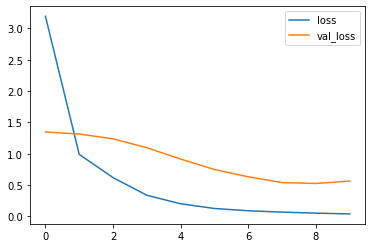

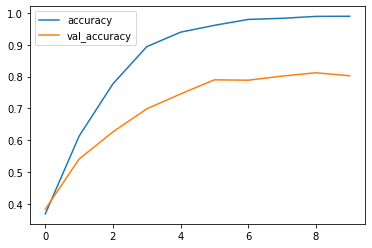

In [23]:
results = pd.DataFrame(history.history)
results[['loss', 'val_loss']].plot()
results[['accuracy', 'val_accuracy']].plot()

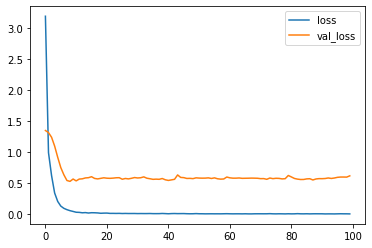

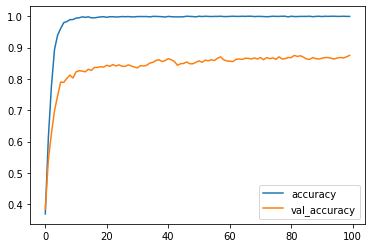

In [26]:
results = pd.concat([results, pd.DataFrame(history.history)], ignore_index=True)
results[['loss', 'val_loss']].plot()
results[['accuracy', 'val_accuracy']].plot()

In [27]:
results.tail()

,loss,accuracy,val_loss,val_accuracy
95,0.002484,0.9995,0.592212,0.866978
96,0.003723,0.9995,0.596679,0.868145
97,0.002816,1.0000,0.596875,0.866978
98,0.002625,0.9995,0.595835,0.870478
99,0.001548,0.9995,0.616286,0.875146


In [0]:
model.save('/content/drive/My Drive/kikagaku/novelapp/category-2_model.h5', include_optimizer=False)

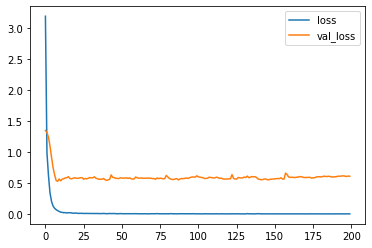

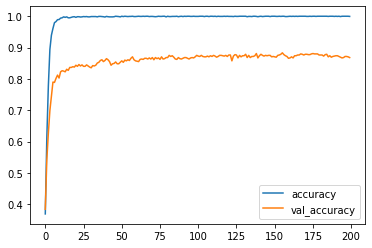

In [30]:
results = pd.concat([results, pd.DataFrame(history.history)], ignore_index=True)
results[['loss', 'val_loss']].plot()
results[['accuracy', 'val_accuracy']].plot()

In [31]:
results.tail()

,loss,accuracy,val_loss,val_accuracy
195,0.001103,1.0000,0.615440,0.868145
196,0.000797,1.0000,0.609427,0.871645
197,0.000729,1.0000,0.605343,0.871645
198,0.001288,1.0000,0.612647,0.870478
199,0.001258,0.9995,0.608839,0.868145
